In [2]:
import scanpy as sc
import os
import numpy as np


import sys
sys.path.append('../Utils')
sys.path.insert(0, '../../FRLC/src/')
import warnings
warnings.filterwarnings("ignore")


import Solve_Slice_test
from Solve_Slice_test import find_B, solve_V_per_slice, laplacian_from_coords, solve_V_all_slices, find_B_music
from Solve_Slice_test import select_informative_genes
from Plot_utils import global_cluster_then_per_slice_ari, plot_mass_transport_heatmap,plot_slices_horizontal_centered

from jobs_ZESTA import prepare_data

from Impute import compare_imputation_midpoint, pca_align_then_temporal_flip, rotate_points


import anndata as ad
import numpy as np
import scanpy as sc
%load_ext autoreload
%autoreload 2

# Load data. 

Change fname according to local directories. Both scRNA and spatial data can be downloaded from:
https://db.cngb.org/stomics/zesta/download/

The resulting adata_insamp is a list of adata objects containing spatial transcriptomics. pd_B is the reference matrix representing mean expression for cell types. 

In [3]:
adata_insamp, pd_B = prepare_data(threshold=1.25, return_sc=False, data_dir = '../../../')

../../../


# Run ATLIS. 

In [6]:
time = [3,5,10,12,18,24]

In [11]:
V, pi, aux = solve_V_all_slices(
                        adata_insamp, pd_B, time=time,
                        lam=1e5, mu=1e1, 
                        verbose=False,
                        ot_solver='low_rank',
                        alpha = 0.5
                    )

iter    0  f=2.269080e+08  rel_drop=9.757e-01  mean step=9.73e-07
iter   50  f=1.027297e+06  rel_drop=2.472e-04  mean step=1.24e-07
iter  100  f=1.021944e+06  rel_drop=1.576e-05  mean step=9.17e-08
iter  106  f=1.021871e+06  rel_drop=9.705e-06  mean step=9.04e-08
stopped after iteration # 106
iter    0  f=1.091367e+08  rel_drop=9.759e-01  mean step=9.72e-07
iter   50  f=2.121700e+05  rel_drop=7.678e-05  mean step=5.62e-07
iter  100  f=2.118189e+05  rel_drop=1.589e-05  mean step=4.93e-07
iter  124  f=2.117557e+05  rel_drop=9.828e-06  mean step=4.76e-07
stopped after iteration # 124
iter    0  f=2.019017e+08  rel_drop=9.757e-01  mean step=9.74e-07
iter   50  f=2.784564e+05  rel_drop=2.230e-04  mean step=4.47e-07
iter  100  f=2.769501e+05  rel_drop=5.712e-05  mean step=3.77e-07
iter  150  f=2.763903e+05  rel_drop=2.942e-05  mean step=3.46e-07
iter  200  f=2.760939e+05  rel_drop=1.465e-05  mean step=3.27e-07
iter  223  f=2.760173e+05  rel_drop=9.977e-06  mean step=3.21e-07
stopped after it

In [12]:

ari_avg = 0
import matplotlib.pyplot as plt
out = global_cluster_then_per_slice_ari(
            V,
            adata_insamp,
            celltype_key="bin_annotation",
            embedding_key="spatial",
            clustering="louvain",
            plot=False,
            auto_mode='match_k',
            return_pred=True
)

print(out["mean_ari"])
ari_ours = np.asarray(list(out["per_slice_ari"].values()), dtype=float)
nmi_ours = np.asarray(list(out["per_slice_nmi"].values()), dtype=float)
for i in range(len(adata_insamp)):
    adata_insamp[i].obs['ours'] = out['pred_labels'][i]

ari_global_ours = out["global_ari"]
nmi_global_ours = out["global_nmi"]


Louvain: target_k=45, best_resolution=1.344, n_clusters=45
0.26297968473890027


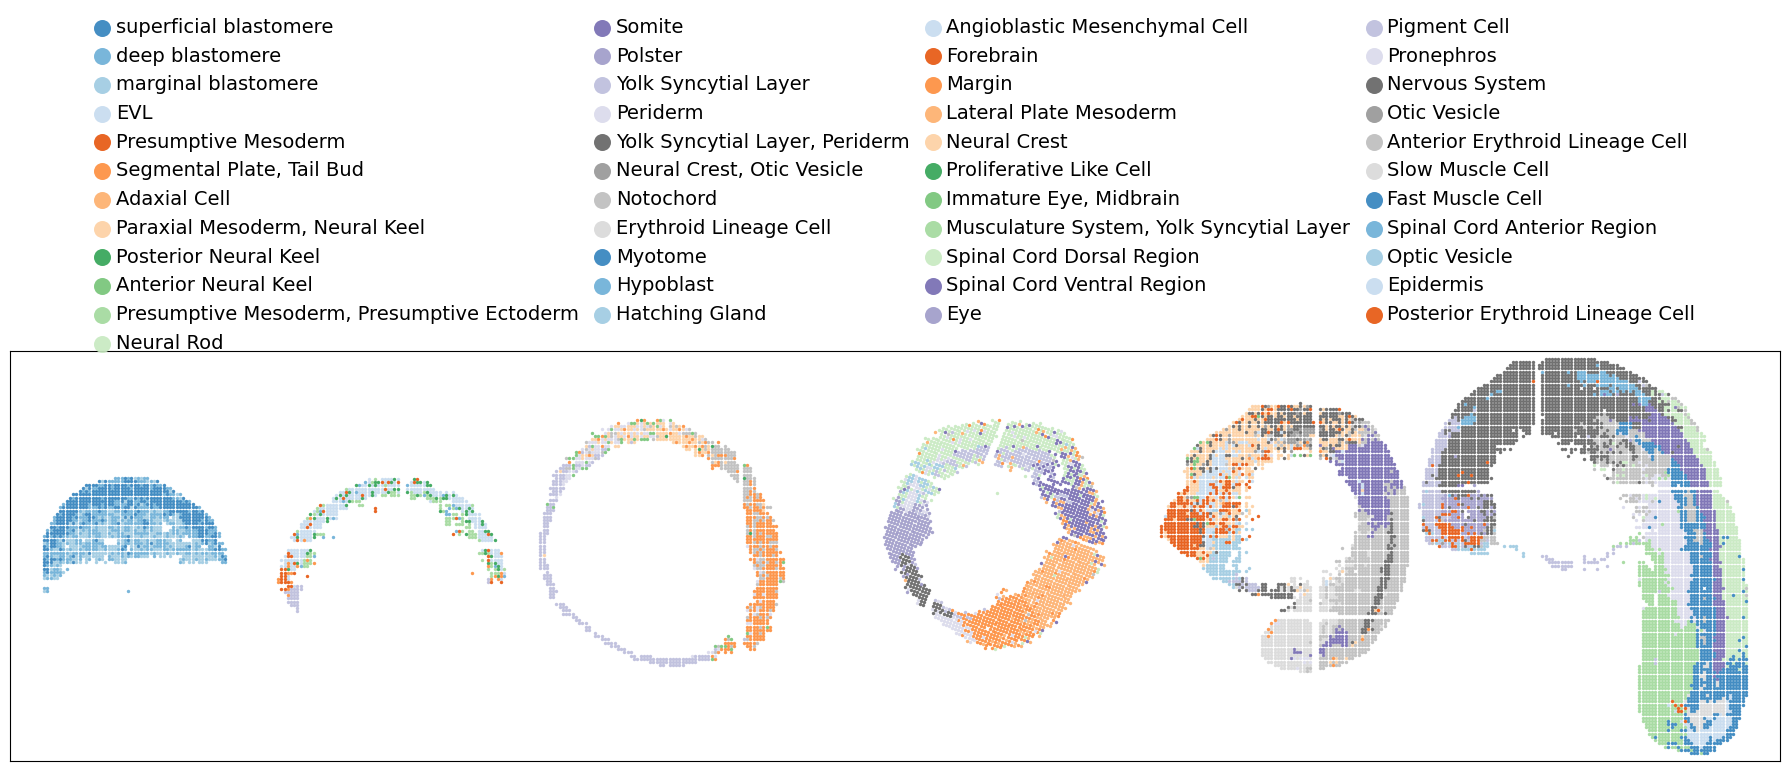

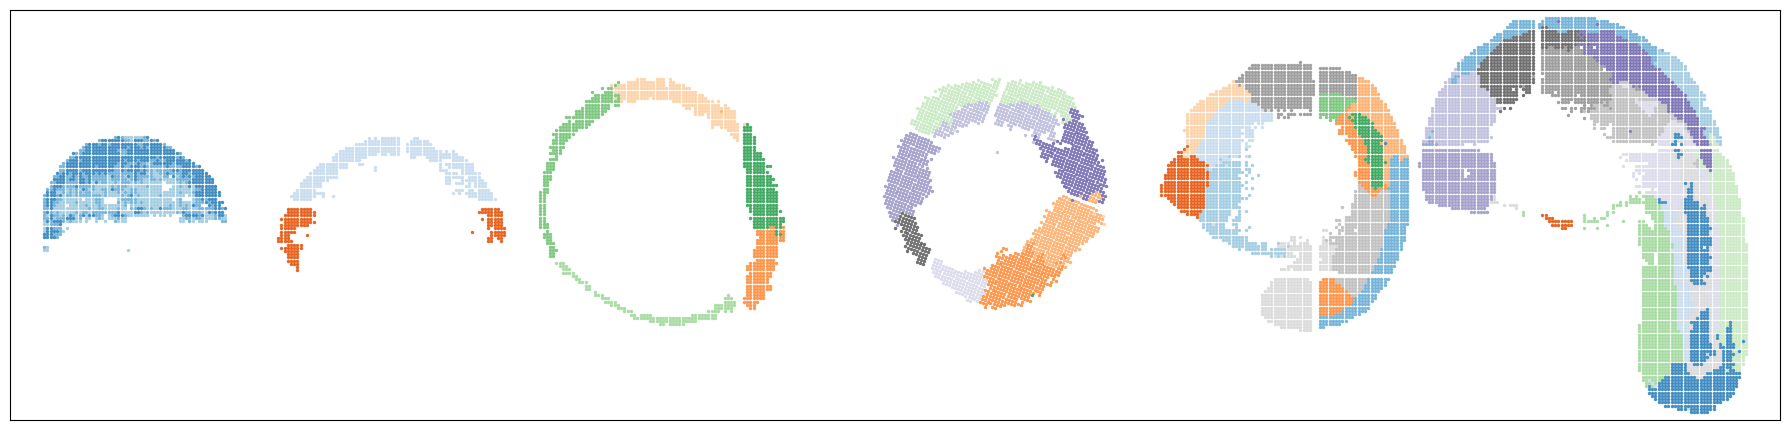

In [15]:
cmap = 'tab20c'
fig, ax = plot_slices_horizontal_centered(
    adata_list=adata_insamp,
    obs_key="bin_annotation",
    coord_keys=("x", "y"),      # uses ad.obs['x'], ad.obs['y'] if present
    obsm_key="spatial",         # otherwise uses ad.obsm['spatial'][:, :2]
    order_key=None,     # optional; requires each slice has exactly one time_point
    # order_map={"E10.5": 10.5, "E11.5": 11.5},  # optional helper
    y_scale=1.0,
    x_gap = 350,
    s=6,
    legend_loc='upper center',
    legend_bbox=(0.5,1.41),
    legend_ncol = 4,
    legend_font=14,
    truth_cmap=cmap,
    truth_key='ours'
)

cmap = 'tab20c'
fig, ax = plot_slices_horizontal_centered(
    adata_list=adata_insamp,
    obs_key="ours",
    coord_keys=("x", "y"),      # uses ad.obs['x'], ad.obs['y'] if present
    obsm_key="spatial",         # otherwise uses ad.obsm['spatial'][:, :2]
    order_key=None,     # optional; requires each slice has exactly one time_point
    # order_map={"E10.5": 10.5, "E11.5": 11.5},  # optional helper
    legend=False,
    y_scale=1.0,
    x_gap = 350,
    s=6,
    truth_cmap=cmap,
    truth_key='ours'
)

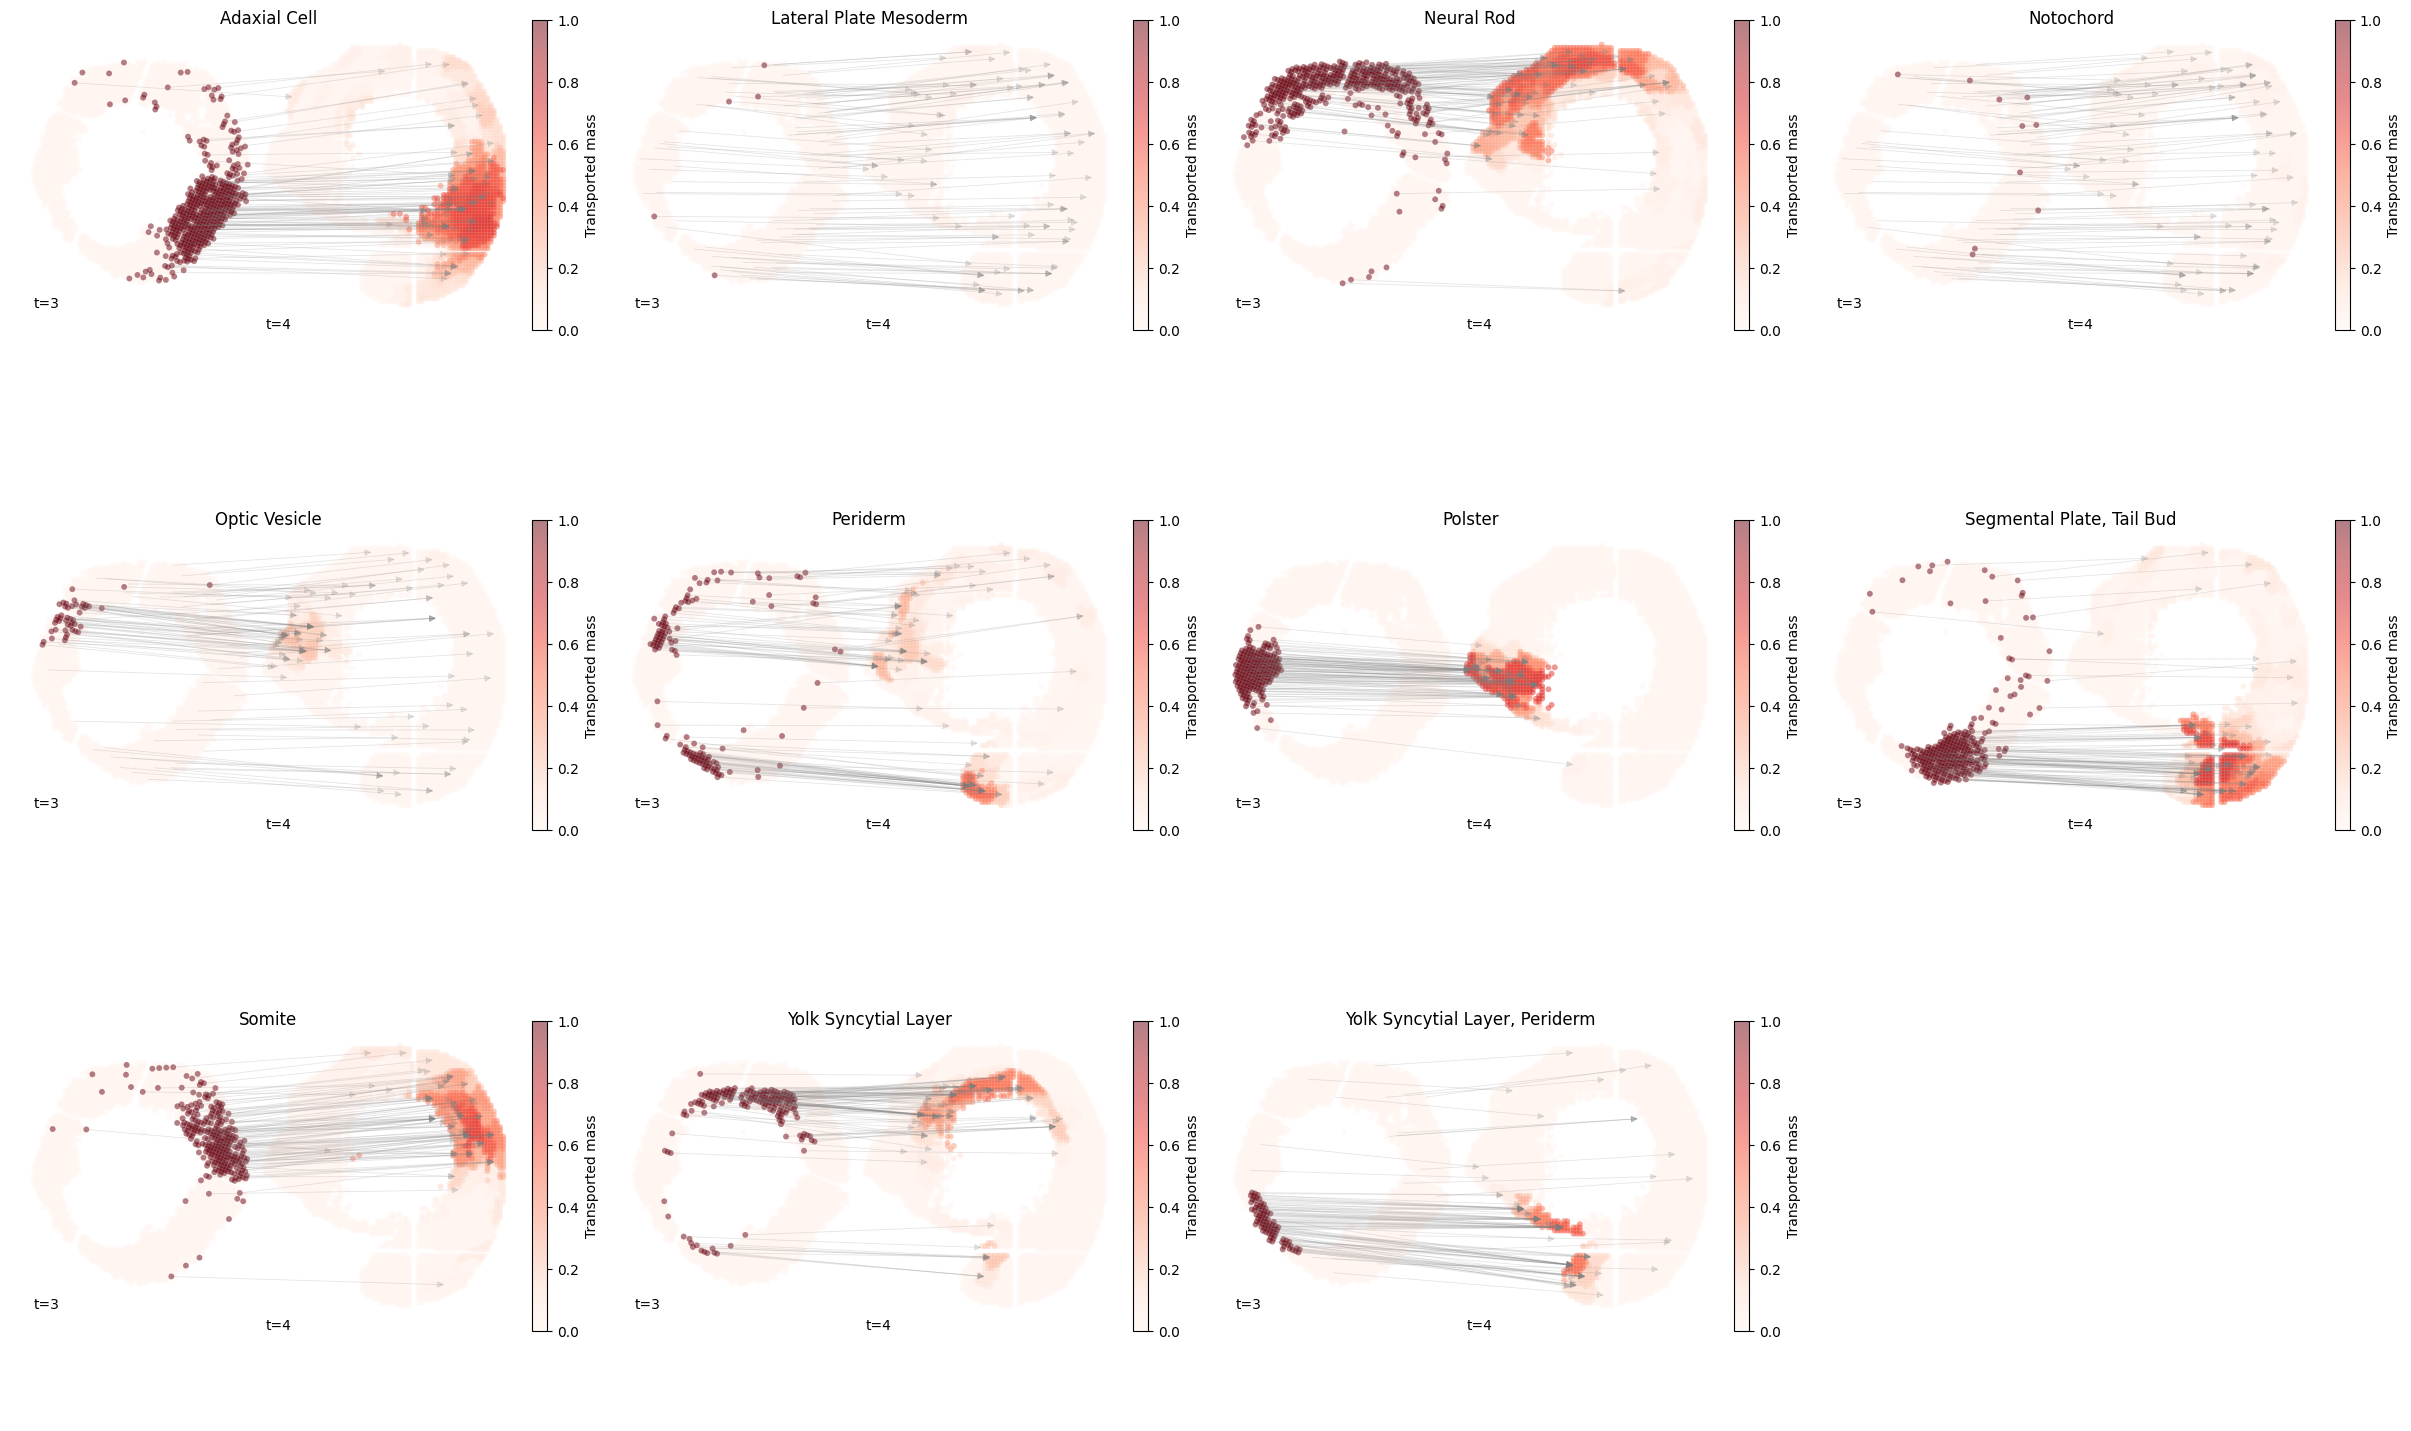

In [18]:
import math
cell_types = list(adata_insamp[3].obs["bin_annotation"].unique())
cell_types = sorted(cell_types)   
n = len(cell_types)

ncols = 4                         
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(6 * ncols, 5 * nrows),   
    constrained_layout=True
)
axes = np.asarray(axes).reshape(-1)


for i, cell_type in enumerate(cell_types):
    ax = axes[i]

    
    fig_i, ax_i, masses = plot_mass_transport_heatmap(
        adata_insamp,
        V,
        pi,
        t_start=3,
        t_end=4,
        source_celltype=cell_type,
        celltype_obs_key="bin_annotation",
        source_mass_source="obs",
        y_gap=1200,
        y_scale=1.0,
        show_edges=True,
        n_sources_show = 100,
        alpha=0.5,
        cmap="Reds",
        edge_alpha=0.2,
        ax=ax,         
        fig=fig,       
       
    )

    ax.set_title(str(cell_type), fontsize=12)


for j in range(n, len(axes)):
    axes[j].axis("off")

# Now try an interpolation between the first and last slices

In [19]:
i = 4
X_all, V_all, t_grid, gw_dists = compare_imputation_midpoint(adata_insamp, V, pd_B, i, n_end=1000)



a=0,b=16
a=0,b=8
a=8,b=16
a=0,b=4
a=4,b=8
a=8,b=12
a=12,b=16
a=0,b=2
a=2,b=4
a=4,b=6
a=6,b=8
a=8,b=10
a=10,b=12
a=12,b=14
a=14,b=16
t = 0.062500
GW = 0.004175177676576799
t = 0.125000
GW = 0.0025933796860938612
t = 0.187500
GW = 0.002854479540934181
t = 0.250000
GW = 0.005006650081456794
t = 0.312500
GW = 0.008531812079814903
t = 0.375000
GW = 0.014004858071794959
t = 0.437500
GW = 0.021135686176270697
t = 0.500000
GW = 0.031148495507673176
t = 0.562500
GW = 0.0408642031115822
t = 0.625000
GW = 0.053470999940356014
t = 0.687500
GW = 0.06774321169281902
t = 0.750000
GW = 0.08416119756392813
t = 0.812500
GW = 0.10190106212592465
t = 0.875000
GW = 0.12177990481540078
t = 0.937500
GW = 0.14338280165021852


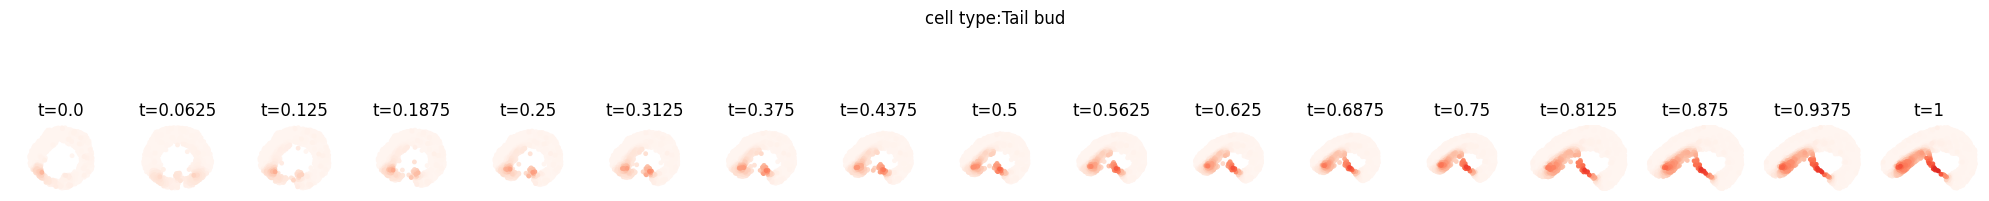

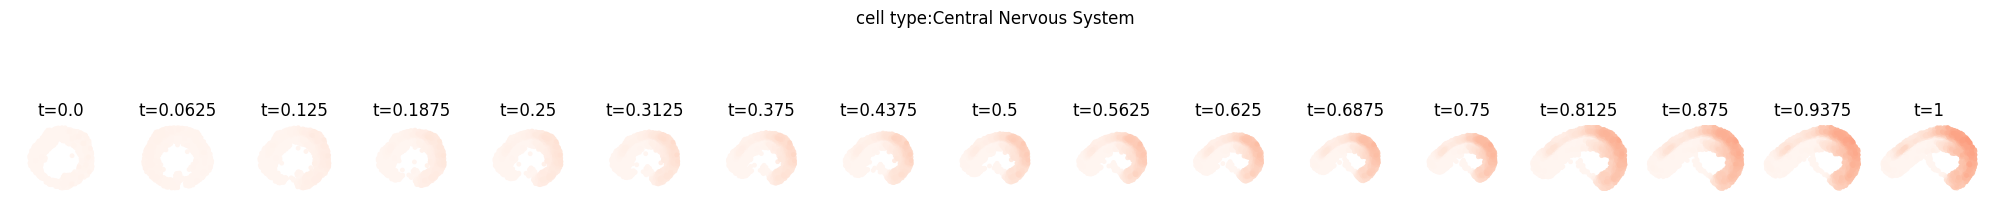

In [51]:
import matplotlib.pyplot as plt
type_id = 47
i = 4

plt.rcParams['figure.figsize'] = (20,2)
plt.rcParams['font.size'] = 10
t_grid = list(np.array(range(16))*1/16) + [1]
ad0, adt, ad1 = adata_insamp[i - 1], adata_insamp[i], adata_insamp[i + 1]


V0 = np.asarray(V[i - 1], float)
Vt = np.asarray(V[i], float)
V1 = np.asarray(V[i + 1], float)

def coords(ad):
        return ad.obs[["x", "y"]].to_numpy(dtype=float)

X0 = coords(ad0)
Xt = coords(adt)
X1 = coords(ad1)

for counter in range(len(t_grid)):
        

        Ybar = V_all[counter+3]
        Xbar = X_all[counter+3]
        
        Xbar = pca_align_then_temporal_flip(Xbar, Xt)
        if t_grid[counter] <= 0.9 and t_grid[counter] > 0.1:
                Xbar[:,1] = -Xbar[:,1]

        plt.subplot(2,len(t_grid),len(t_grid) + 1+counter)
        Ybar = Ybar / np.sum(Ybar,axis=1).reshape(-1,1)
        order = np.argsort(Ybar[:,type_id])
        plt.scatter(Xbar[order,0],Xbar[order,1], c=Ybar[order,type_id], s=6, cmap='Reds')
        plt.title('t='+str(t_grid[counter]))
        plt.clim([0,1])
        plt.axis('off')
        plt.axis('equal')
plt.tight_layout()
plt.suptitle('cell type:' + pd_B.index[type_id] )
plt.show()


type_id = 33#49


for counter in range(len(t_grid)):
        

        Ybar = V_all[counter+3]
        Xbar = X_all[counter+3]
        
        Xbar = pca_align_then_temporal_flip(Xbar, Xt)
        if t_grid[counter] <= 0.9 and t_grid[counter] > 0.1:
                Xbar[:,1] = -Xbar[:,1]

        plt.subplot(2,len(t_grid),len(t_grid) + 1+counter)
        Ybar = Ybar / np.sum(Ybar,axis=1).reshape(-1,1)
        order = np.argsort(Ybar[:,type_id])
        plt.scatter(Xbar[order,0],Xbar[order,1], c=Ybar[order,type_id], s=6, cmap='Reds')
        plt.title('t='+str(t_grid[counter]))
        plt.clim([0,1])
        plt.axis('off')
        plt.axis('equal')
plt.tight_layout()
plt.suptitle('cell type:' + pd_B.index[type_id] )
plt.show()

# To inspect a specific gene:

[3967 1931 2713 ...  143 2234 3899]
[1270 1764 1281 ...  263   46  157]


Text(0.5, 0.98, 'gene expression: krt4')

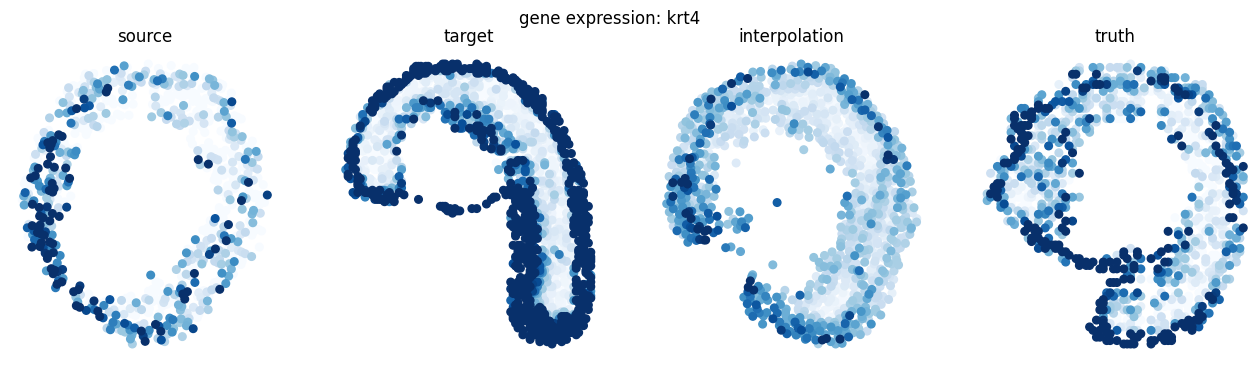

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def coords(ad):
    return ad.obs[["x", "y"]].to_numpy(dtype=float)

counter = 3
Ybar = V_all[counter+3]

Xbar = X_all[counter+3]

common_genes = adata_insamp[4].var_names.intersection(pd_B.columns)
adata_sub = adata_insamp[4][:, common_genes].copy()
pd_B_sub = pd_B.loc[:, common_genes]
Xt = coords(adata_sub)
Yt = adata_sub.X.todense()
Y_bar_gene = Ybar @ pd_B_sub.values

Xt = coords(adata_insamp[4])
Yt = adata_insamp[4][:,pd_B_sub.columns].X.todense()


adata_sub = adata_insamp[3][:, common_genes].copy()
pd_B_sub = pd_B.loc[:, common_genes]
Xt1 = coords(adata_sub)
Yt1 = adata_sub.X.todense()

adata_sub = adata_insamp[5][:, common_genes].copy()
pd_B_sub = pd_B.loc[:, common_genes]
Xt2 = coords(adata_sub)
Yt2 = adata_sub.X.todense()

plt.rcParams['figure.figsize'] = (16,4)
plt.subplot(1,4,1)
gene = 7922
order = np.argsort(np.array(Yt1[:,gene]).ravel())
order = order[::3]
plt.scatter(Xt1[order,0], Xt1[order,1], c=np.array(Yt1[order,gene]), s=30, cmap='Blues')
plt.clim([0,100])
plt.axis('off')
# plt.axis('equal')
plt.title('source')
plt.subplot(1,4,2)
order = np.argsort(np.array(Yt2[:,gene]).ravel())
order = order[::3]
print(order)
plt.scatter(Xt2[order,0], Xt2[order,1], c=np.array(Yt2[order,gene]), s=30, cmap='Blues')
plt.axis('off')
plt.clim([0,100])
plt.title('target')


plt.subplot(1,4,3)
Xbar = X_all[counter+3]
Xt = coords(adata_insamp[4])


Xbar = -pca_align_then_temporal_flip(Xbar, Xt)
Xbar = rotate_points(Xbar, angle_deg=-60, center=Xbar.mean(axis=0))
Y_bar_gene = Y_bar_gene / Y_bar_gene.sum(axis=1).reshape(-1,1) * Yt.sum(axis=1).mean()


order = np.argsort(Y_bar_gene[:,gene])
plt.scatter(Xbar[order,0], Xbar[order,1], c=Y_bar_gene[order,gene], s=30, cmap='Blues')
plt.clim([0,100])
plt.axis('off')
plt.axis('equal')
plt.title('interpolation')
plt.subplot(1,4,4)
order = np.argsort(np.array(Yt[:,gene]).ravel())
order = order[::3]
print(order)
# Xt = rotate_points(Xt, angle_deg=-35, center=Xbar.mean(axis=0))
plt.scatter(Xt[order,0], Xt[order,1], c=np.array(Yt[order,gene]), s=30, cmap='Blues')
plt.axis('off')
plt.axis('equal')
plt.clim([0,100])
plt.title('truth')

plt.suptitle('gene expression: ' + adata_insamp[0].var_names[gene] )